# Análise de Comportamento do Cliente

Este notebook analisa o comportamento dos clientes do e-commerce da Olist, explorando padrões de compra, segmentação de clientes e fatores que influenciam a satisfação e fidelidade.

## Importação de Bibliotecas

In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import sys

# Adicionando diretório src ao path para importar módulos personalizados
sys.path.append('../src')
import data_cleaning as dc
import visualization as viz

%matplotlib inline

# Configurações de visualização
viz.set_visualization_style()

## Carregamento dos Dados

Carregamos os dados processados dos notebooks anteriores e os dados brutos necessários para esta análise.

In [2]:
# Verificando se os dados processados existem
if os.path.exists('../data/processed/orders_processed.csv') and os.path.exists('../data/processed/merged_data_processed.csv'):
    orders = pd.read_csv('../data/processed/orders_processed.csv')
    merged_data = pd.read_csv('../data/processed/merged_data_processed.csv')
    
    # Convertendo colunas de data para datetime
    date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                    'order_delivered_customer_date', 'order_estimated_delivery_date']
    for col in date_columns:
        if col in orders.columns:
            orders[col] = pd.to_datetime(orders[col])
else:
    # Se não existir, usar funções do módulo data_cleaning para preparar os dados
    print("Dados processados não encontrados. Preparando dados...")
    datasets = dc.prepare_data_for_analysis(save_processed=True)
    orders = datasets['orders']
    merged_data = datasets['merged_data']

# Carregando dados de clientes
if os.path.exists('../data/raw/olist_customers_dataset.csv'):
    customers = pd.read_csv('../data/raw/olist_customers_dataset.csv')
else:
    # Criando dados de exemplo
    customers_data = {
        'customer_id': [f'cust_{i}' for i in range(1, 101)],
        'customer_unique_id': [f'uniq_{i}' for i in range(1, 101)],
        'customer_zip_code_prefix': np.random.randint(10000, 99999, 100),
        'customer_city': np.random.choice(['São Paulo', 'Rio de Janeiro', 'Belo Horizonte', 'Porto Alegre', 'Brasília'], 100),
        'customer_state': np.random.choice(['SP', 'RJ', 'MG', 'RS', 'DF'], 100)
    }
    customers = pd.DataFrame(customers_data)
    os.makedirs('../data/raw', exist_ok=True)
    customers.to_csv('../data/raw/olist_customers_dataset.csv', index=False)

# Carregando dados de avaliações
if os.path.exists('../data/raw/olist_order_reviews_dataset.csv'):
    reviews = pd.read_csv('../data/raw/olist_order_reviews_dataset.csv')
else:
    # Criando dados de exemplo
    reviews_data = {
        'review_id': [f'review_{i}' for i in range(1, 201)],
        'order_id': [f'order_{i}' for i in range(1, 201)],
        'review_score': np.random.randint(1, 6, 200),
        'review_comment_title': [f'Title {i}' if i % 3 == 0 else None for i in range(1, 201)],
        'review_comment_message': [f'Message {i}' if i % 2 == 0 else None for i in range(1, 201)],
        'review_creation_date': pd.date_range(start='2022-01-01', end='2022-12-31', periods=200).astype(str),
        'review_answer_timestamp': pd.date_range(start='2022-01-02', end='2023-01-01', periods=200).astype(str)
    }
    reviews = pd.DataFrame(reviews_data)
    os.makedirs('../data/raw', exist_ok=True)
    reviews.to_csv('../data/raw/olist_order_reviews_dataset.csv', index=False)

Dados processados não encontrados. Preparando dados...
Datasets carregados com sucesso!
orders: 200 linhas, 8 colunas
order_items: 300 linhas, 7 colunas
products: 150 linhas, 9 colunas
customers: 100 linhas, 5 colunas
sellers: 50 linhas, 4 colunas
Dados processados salvos em ../data/processed/


## Preparação dos Dados para Análise de Clientes

In [3]:
# Juntando dados de pedidos, clientes e avaliações
orders_customers = pd.merge(orders, customers, on='customer_id', how='inner')
orders_customers_reviews = pd.merge(orders_customers, reviews, on='order_id', how='left')

# Verificando o resultado da junção
print(f"Número de registros após junção: {len(orders_customers_reviews)}")
orders_customers_reviews.head()

Número de registros após junção: 200


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_year,order_purchase_timestamp_month,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,order_1,cust_19,delivered,2022-01-01 00:00:00.000000000,2022-01-01 00:00:00.000000000,2022-01-02 00:00:00.000000000,2022-01-05 00:00:00.000000000,2022-01-10 00:00:00.000000000,2022,1,...,uniq_19,33661,São Paulo,RJ,review_1,2,None,None,2022-01-01 00:00:00.000000000,2022-01-02 00:00:00.000000000
1,order_2,cust_87,shipped,2022-01-02 19:53:58.190954773,2022-01-02 19:53:58.190954773,2022-01-03 19:53:58.190954773,2022-01-06 20:01:12.361809045,2022-01-11 20:01:12.361809045,2022,1,...,uniq_87,86921,Brasília,RJ,review_2,5,None,Message 2,2022-01-02 19:53:58.190954773,2022-01-03 19:53:58.190954773
2,order_3,cust_52,delivered,2022-01-04 15:47:56.381909547,2022-01-04 15:47:56.381909547,2022-01-05 15:47:56.381909547,2022-01-08 16:02:24.723618090,2022-01-13 16:02:24.723618090,2022,1,...,uniq_52,21219,São Paulo,RJ,review_3,1,Title 3,None,2022-01-04 15:47:56.381909547,2022-01-05 15:47:56.381909547
3,order_4,cust_31,canceled,2022-01-06 11:41:54.572864321,2022-01-06 11:41:54.572864321,2022-01-07 11:41:54.572864321,2022-01-10 12:03:37.085427135,2022-01-15 12:03:37.085427135,2022,1,...,uniq_31,28132,Porto Alegre,RJ,review_4,2,None,Message 4,2022-01-06 11:41:54.572864321,2022-01-07 11:41:54.572864321
4,order_5,cust_62,canceled,2022-01-08 07:35:52.763819095,2022-01-08 07:35:52.763819095,2022-01-09 07:35:52.763819095,2022-01-12 08:04:49.447236180,2022-01-17 08:04:49.447236180,2022,1,...,uniq_62,13307,Belo Horizonte,RS,review_5,3,None,None,2022-01-08 07:35:52.763819095,2022-01-09 07:35:52.763819095


## Análise de Frequência de Compra

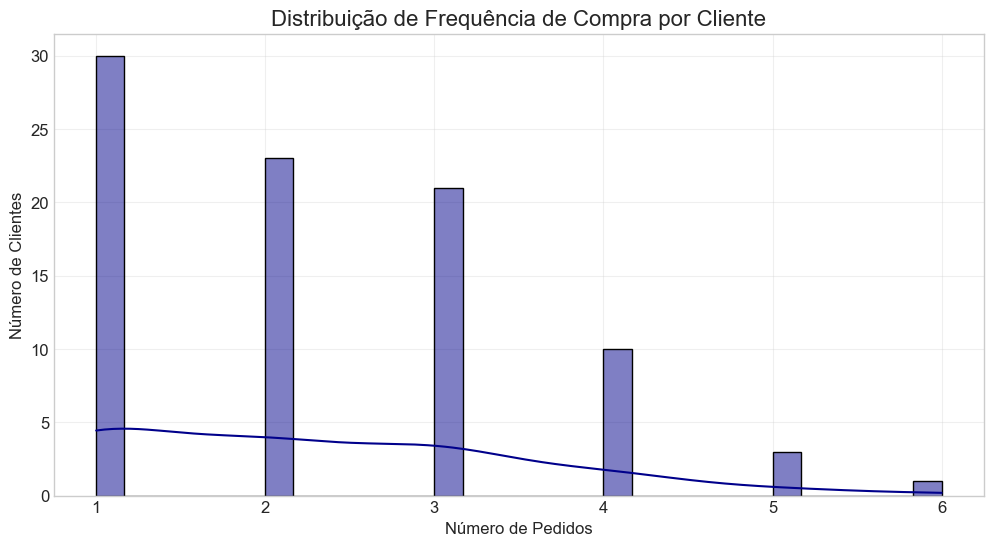

Estatísticas de frequência de compra:
count    88.000000
mean      2.272727
std       1.210370
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       6.000000
Name: order_count, dtype: float64

Distribuição de clientes por número de pedidos:
   num_orders  num_customers  percentage
0           1             30   34.090909
1           2             23   26.136364
2           3             21   23.863636
3           4             10   11.363636
4           5              3    3.409091
5           6              1    1.136364


In [4]:
# Analisando frequência de compra por cliente
customer_frequency = orders_customers.groupby('customer_unique_id')['order_id'].count().reset_index()
customer_frequency.columns = ['customer_unique_id', 'order_count']

# Visualizando distribuição de frequência de compra
plt.figure(figsize=(12, 6))
sns.histplot(customer_frequency['order_count'], kde=True, bins=30, color='darkblue')
plt.title('Distribuição de Frequência de Compra por Cliente', fontsize=16)
plt.xlabel('Número de Pedidos', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/customer_purchase_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

# Estatísticas descritivas
print("Estatísticas de frequência de compra:")
print(customer_frequency['order_count'].describe())

# Contagem de clientes por número de pedidos
order_count_distribution = customer_frequency['order_count'].value_counts().sort_index().reset_index()
order_count_distribution.columns = ['num_orders', 'num_customers']
order_count_distribution['percentage'] = order_count_distribution['num_customers'] / order_count_distribution['num_customers'].sum() * 100

print("\nDistribuição de clientes por número de pedidos:")
print(order_count_distribution)

## Análise de Recência, Frequência e Valor (RFM)

Data de referência para análise RFM: 2023-01-01 00:00:00


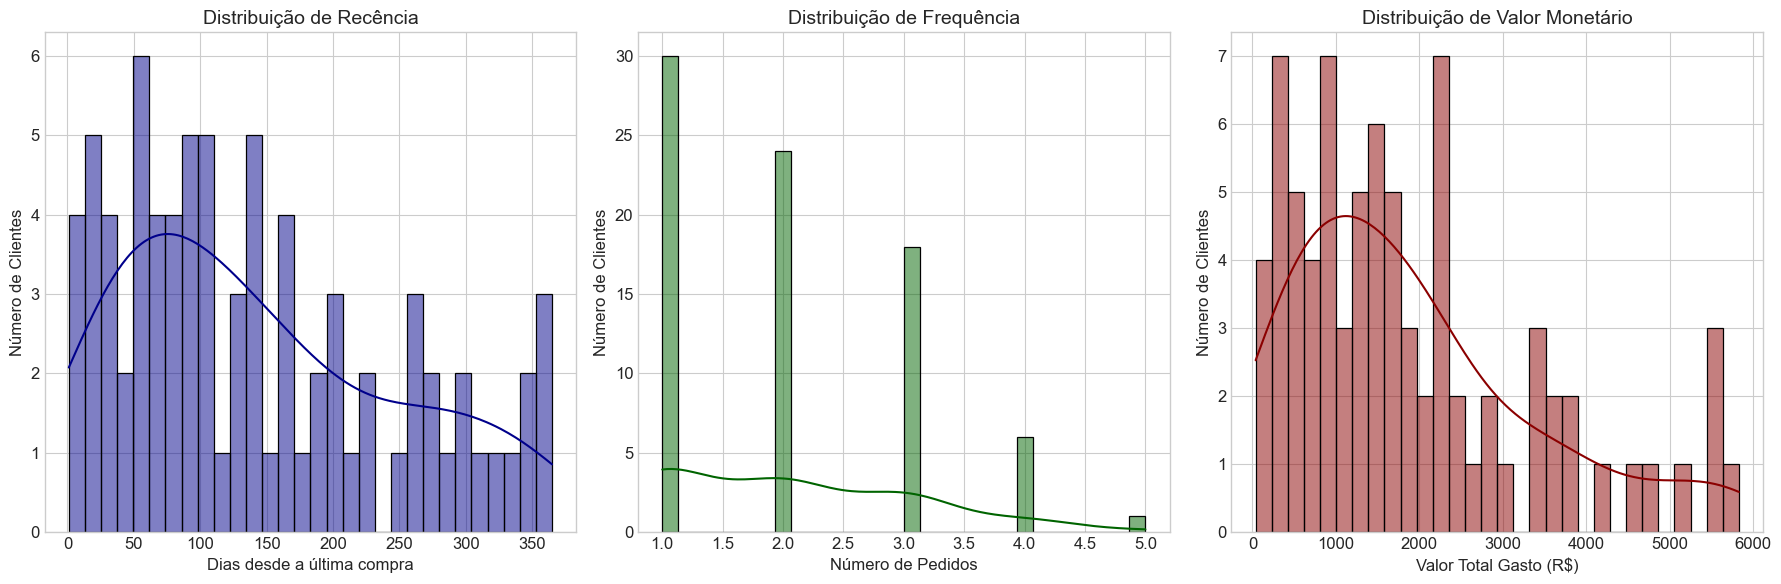

C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\1540079791.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=segment_counts.index, x=segment_counts.values, palette='viridis')


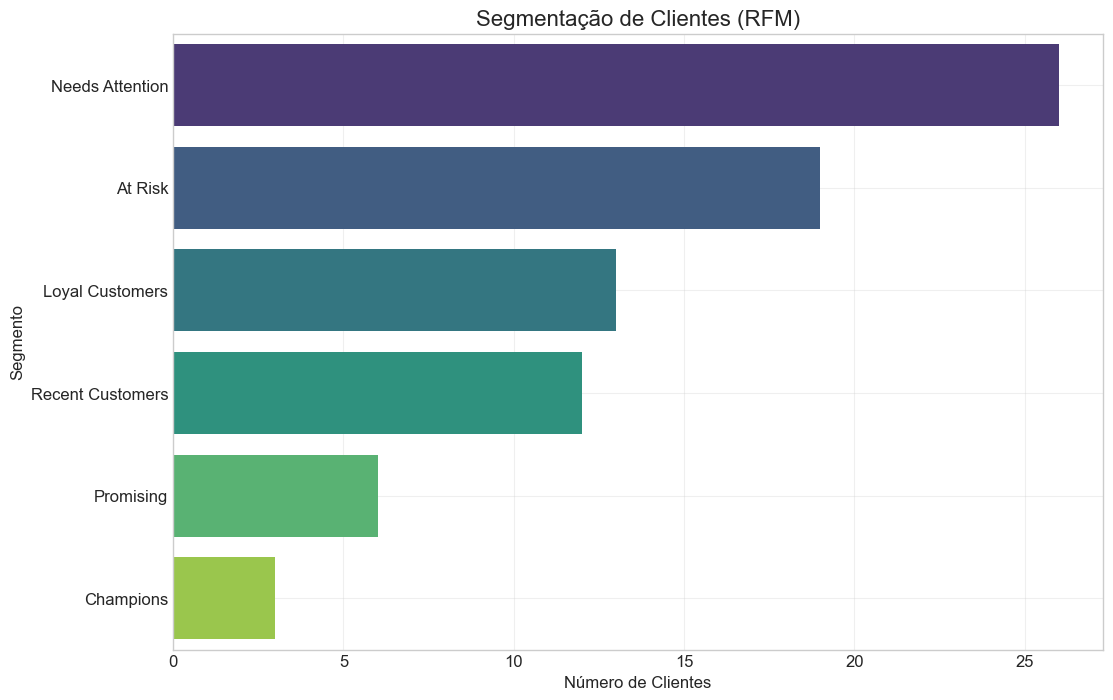


Estatísticas por segmento de cliente:
            segment  avg_recency  avg_frequency  avg_monetary  customer_count  \
1         Champions    25.000000       4.000000   4238.810000               3   
2   Loyal Customers    51.923077       3.230769   4026.094615              13   
4         Promising   149.833333       2.833333   2931.583333               6   
5  Recent Customers    57.500000       2.250000   1718.157500              12   
3   Needs Attention   142.192308       1.615385   1399.234615              26   
0           At Risk   275.315789       1.105263    553.842632              19   

   percentage  
1    3.797468  
2   16.455696  
4    7.594937  
5   15.189873  
3   32.911392  
0   24.050633  


In [5]:
# Calculando métricas RFM (Recência, Frequência, Valor)
# Definindo a data de referência como a data mais recente no dataset + 1 dia
if 'order_purchase_timestamp' in orders.columns and pd.api.types.is_datetime64_dtype(orders['order_purchase_timestamp']):
    reference_date = orders['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
else:
    reference_date = pd.to_datetime('today')

print(f"Data de referência para análise RFM: {reference_date}")

# Preparando dados para análise RFM
rfm_data = merged_data.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (reference_date - pd.to_datetime(x).max()).days,  # Recência em dias
    'order_id': 'nunique',  # Frequência (número de pedidos)
    'price': 'sum'  # Valor monetário total
}).reset_index()

rfm_data.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']

# Visualizando distribuição das métricas RFM
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(rfm_data['recency'], kde=True, bins=30, color='darkblue', ax=axes[0])
axes[0].set_title('Distribuição de Recência', fontsize=14)
axes[0].set_xlabel('Dias desde a última compra', fontsize=12)
axes[0].set_ylabel('Número de Clientes', fontsize=12)

sns.histplot(rfm_data['frequency'], kde=True, bins=30, color='darkgreen', ax=axes[1])
axes[1].set_title('Distribuição de Frequência', fontsize=14)
axes[1].set_xlabel('Número de Pedidos', fontsize=12)
axes[1].set_ylabel('Número de Clientes', fontsize=12)

sns.histplot(rfm_data['monetary'], kde=True, bins=30, color='darkred', ax=axes[2])
axes[2].set_title('Distribuição de Valor Monetário', fontsize=14)
axes[2].set_xlabel('Valor Total Gasto (R$)', fontsize=12)
axes[2].set_ylabel('Número de Clientes', fontsize=12)

plt.tight_layout()
plt.savefig('../reports/figures/rfm_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Segmentação de clientes com base em quartis RFM
# Convertendo métricas em scores de 1 a 4 (quartis)
rfm_data['r_score'] = pd.qcut(rfm_data['recency'], 4, labels=False, duplicates='drop')
rfm_data['f_score'] = pd.qcut(rfm_data['frequency'], 4, labels=False, duplicates='drop')
rfm_data['m_score'] = pd.qcut(rfm_data['monetary'], 4, labels=False, duplicates='drop')

# Invertendo o score de recência (menor recência = melhor score)
rfm_data['r_score'] = 3 - rfm_data['r_score']

# Calculando RFM score total
rfm_data['rfm_score'] = rfm_data['r_score'] + rfm_data['f_score'] + rfm_data['m_score']

# Definindo segmentos de clientes
def segment_customer(row):
    if row['rfm_score'] >= 8:
        return 'Champions'
    elif (row['rfm_score'] >= 6) and (row['r_score'] >= 2):
        return 'Loyal Customers'
    elif (row['rfm_score'] >= 6) and (row['r_score'] < 2):
        return 'Potential Loyalists'
    elif (row['rfm_score'] >= 4) and (row['r_score'] >= 2):
        return 'Recent Customers'
    elif (row['rfm_score'] >= 4) and (row['r_score'] < 2):
        return 'Promising'
    elif (row['rfm_score'] >= 2):
        return 'Needs Attention'
    else:
        return 'At Risk'

rfm_data['segment'] = rfm_data.apply(segment_customer, axis=1)

# Visualizando segmentação de clientes
plt.figure(figsize=(12, 8))
segment_counts = rfm_data['segment'].value_counts()
sns.barplot(y=segment_counts.index, x=segment_counts.values, palette='viridis')
plt.title('Segmentação de Clientes (RFM)', fontsize=16)
plt.xlabel('Número de Clientes', fontsize=12)
plt.ylabel('Segmento', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/customer_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

# Estatísticas por segmento
segment_stats = rfm_data.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'customer_unique_id': 'count'
}).reset_index()

segment_stats.columns = ['segment', 'avg_recency', 'avg_frequency', 'avg_monetary', 'customer_count']
segment_stats['percentage'] = segment_stats['customer_count'] / segment_stats['customer_count'].sum() * 100

print("\nEstatísticas por segmento de cliente:")
print(segment_stats.sort_values('avg_monetary', ascending=False))

## Análise de Satisfação do Cliente

C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\1989185725.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_counts.index, y=review_counts.values, palette='viridis')
C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\1989185725.py:10: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig('../reports/figures/review_score_distribution.png', dpi=300, bbox_inches='tight')
C:\Users\Douglas\Downloads\portfolio_analise_dados\portfolio_analise_dados\sales-data-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


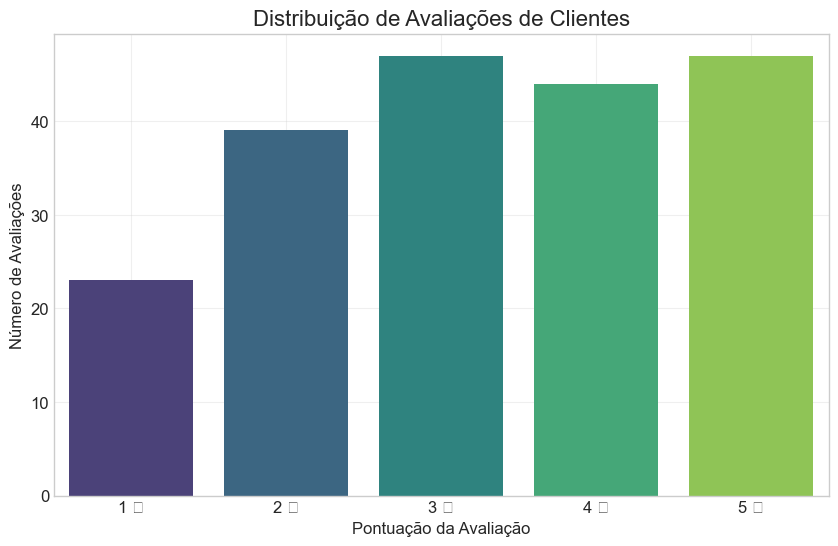

C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\1989185725.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Categoria', y='Percentual', data=nps_data, palette=['green', 'gray', 'red'])


Estatísticas de avaliações:
count    200.000000
mean       3.265000
std        1.324214
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: review_score, dtype: float64

Net Promoter Score (NPS): -31.00%
Promotores: 23.50%
Detratores: 54.50%


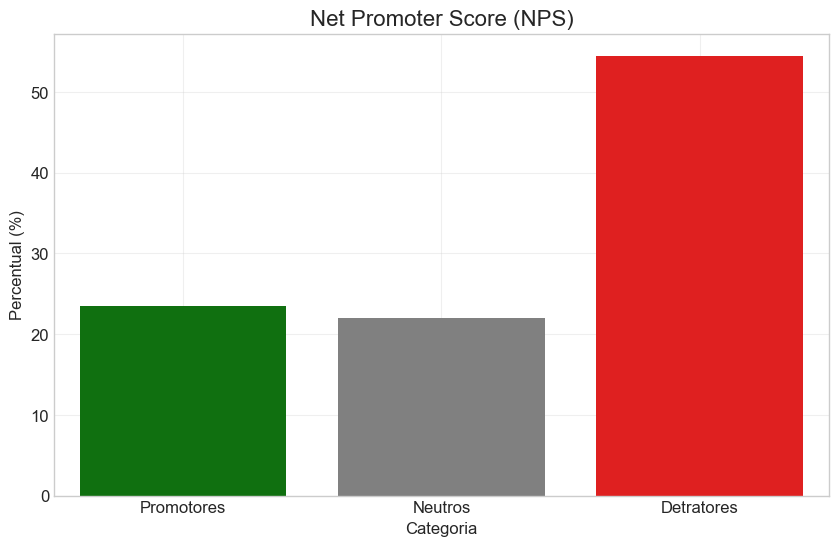

In [6]:
# Analisando distribuição de avaliações
plt.figure(figsize=(10, 6))
review_counts = reviews['review_score'].value_counts().sort_index()
sns.barplot(x=review_counts.index, y=review_counts.values, palette='viridis')
plt.title('Distribuição de Avaliações de Clientes', fontsize=16)
plt.xlabel('Pontuação da Avaliação', fontsize=12)
plt.ylabel('Número de Avaliações', fontsize=12)
plt.xticks(range(5), ['1 ★', '2 ★', '3 ★', '4 ★', '5 ★'])
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/review_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculando estatísticas de avaliações
print("Estatísticas de avaliações:")
print(reviews['review_score'].describe())

# Calculando NPS (Net Promoter Score)
# Promotores: avaliação 5
# Neutros: avaliação 4
# Detratores: avaliação 1-3
total_reviews = len(reviews)
promoters = len(reviews[reviews['review_score'] == 5])
detractors = len(reviews[reviews['review_score'] <= 3])

nps = (promoters / total_reviews * 100) - (detractors / total_reviews * 100)

print(f"\nNet Promoter Score (NPS): {nps:.2f}%")
print(f"Promotores: {promoters / total_reviews * 100:.2f}%")
print(f"Detratores: {detractors / total_reviews * 100:.2f}%")

# Visualizando NPS
plt.figure(figsize=(10, 6))
nps_data = pd.DataFrame({
    'Categoria': ['Promotores', 'Neutros', 'Detratores'],
    'Percentual': [promoters / total_reviews * 100, 
                  (total_reviews - promoters - detractors) / total_reviews * 100, 
                  detractors / total_reviews * 100]
})

sns.barplot(x='Categoria', y='Percentual', data=nps_data, palette=['green', 'gray', 'red'])
plt.title('Net Promoter Score (NPS)', fontsize=16)
plt.xlabel('Categoria', fontsize=12)
plt.ylabel('Percentual (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/nps_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Análise de Fatores que Influenciam a Satisfação

C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\528555060.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_score', y='delivery_time', data=reviews_orders, palette='viridis')
C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\528555060.py:16: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig('../reports/figures/delivery_time_vs_review.png', dpi=300, bbox_inches='tight')
C:\Users\Douglas\Downloads\portfolio_analise_dados\portfolio_analise_dados\sales-data-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


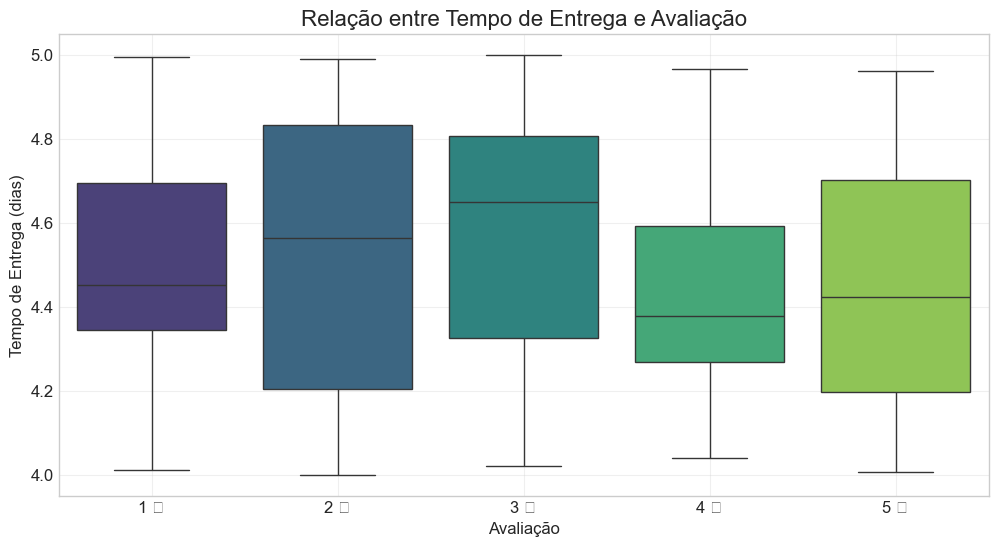

C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\528555060.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_score', y='delivery_delay', data=reviews_orders, palette='viridis')
C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\528555060.py:32: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig('../reports/figures/delivery_delay_vs_review.png', dpi=300, bbox_inches='tight')
C:\Users\Douglas\Downloads\portfolio_analise_dados\portfolio_analise_dados\sales-data-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


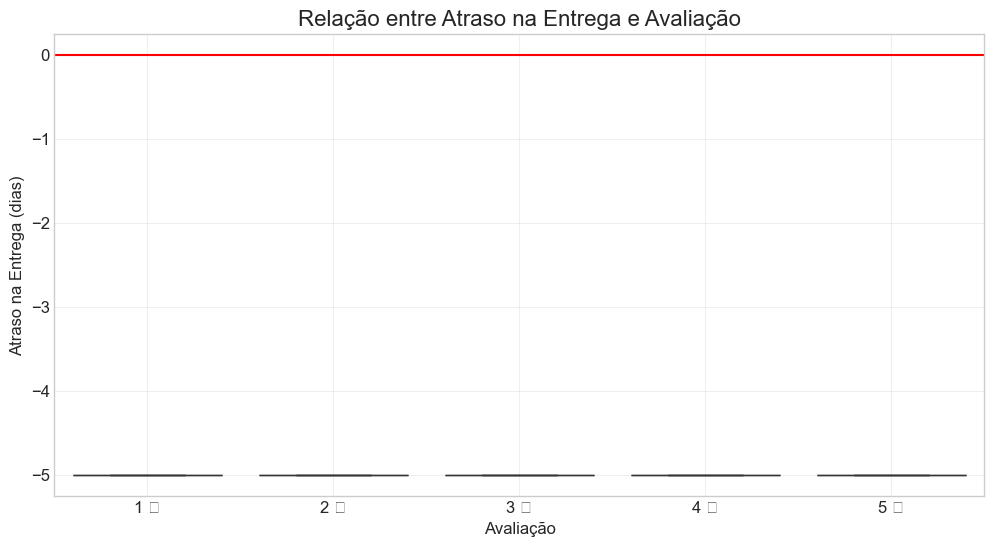

C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\528555060.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_state', y='mean', data=state_reviews, palette='viridis')


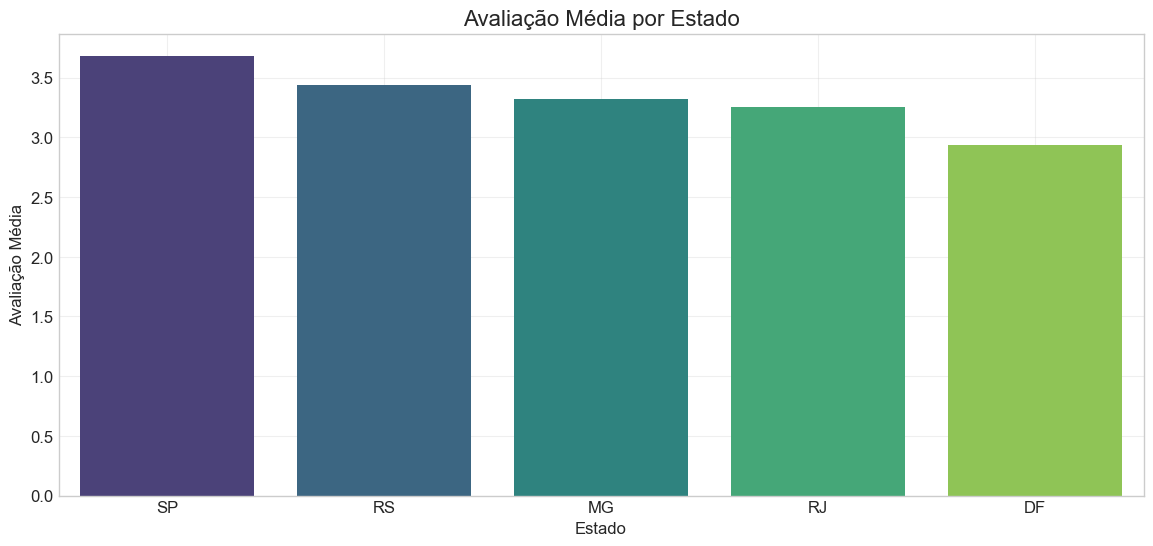

In [7]:
# Juntando dados de avaliações com informações de pedidos
reviews_orders = pd.merge(reviews, orders, on='order_id', how='inner')

# Calculando tempo de entrega
reviews_orders['delivery_time'] = (reviews_orders['order_delivered_customer_date'] - 
                                  reviews_orders['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# Analisando relação entre tempo de entrega e avaliação
plt.figure(figsize=(12, 6))
sns.boxplot(x='review_score', y='delivery_time', data=reviews_orders, palette='viridis')
plt.title('Relação entre Tempo de Entrega e Avaliação', fontsize=16)
plt.xlabel('Avaliação', fontsize=12)
plt.ylabel('Tempo de Entrega (dias)', fontsize=12)
plt.xticks(range(5), ['1 ★', '2 ★', '3 ★', '4 ★', '5 ★'])
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/delivery_time_vs_review.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculando atraso na entrega
reviews_orders['delivery_delay'] = (reviews_orders['order_delivered_customer_date'] - 
                                   reviews_orders['order_estimated_delivery_date']).dt.total_seconds() / (24 * 3600)

# Analisando relação entre atraso na entrega e avaliação
plt.figure(figsize=(12, 6))
sns.boxplot(x='review_score', y='delivery_delay', data=reviews_orders, palette='viridis')
plt.title('Relação entre Atraso na Entrega e Avaliação', fontsize=16)
plt.xlabel('Avaliação', fontsize=12)
plt.ylabel('Atraso na Entrega (dias)', fontsize=12)
plt.xticks(range(5), ['1 ★', '2 ★', '3 ★', '4 ★', '5 ★'])
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/delivery_delay_vs_review.png', dpi=300, bbox_inches='tight')
plt.show()

# Analisando avaliações por estado
reviews_customers = pd.merge(reviews_orders, customers, on='customer_id', how='inner')
state_reviews = reviews_customers.groupby('customer_state')['review_score'].agg(['mean', 'count']).reset_index()
state_reviews = state_reviews.sort_values('mean', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x='customer_state', y='mean', data=state_reviews, palette='viridis')
plt.title('Avaliação Média por Estado', fontsize=16)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Avaliação Média', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/review_by_state.png', dpi=300, bbox_inches='tight')
plt.show()

## Análise de Comentários de Avaliações

C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\2103549264.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comment_by_score.index, y=comment_by_score['Percentual com Comentário'], palette='viridis')
C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\2103549264.py:20: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig('../reports/figures/comment_percentage_by_score.png', dpi=300, bbox_inches='tight')
C:\Users\Douglas\Downloads\portfolio_analise_dados\portfolio_analise_dados\sales-data-analysis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


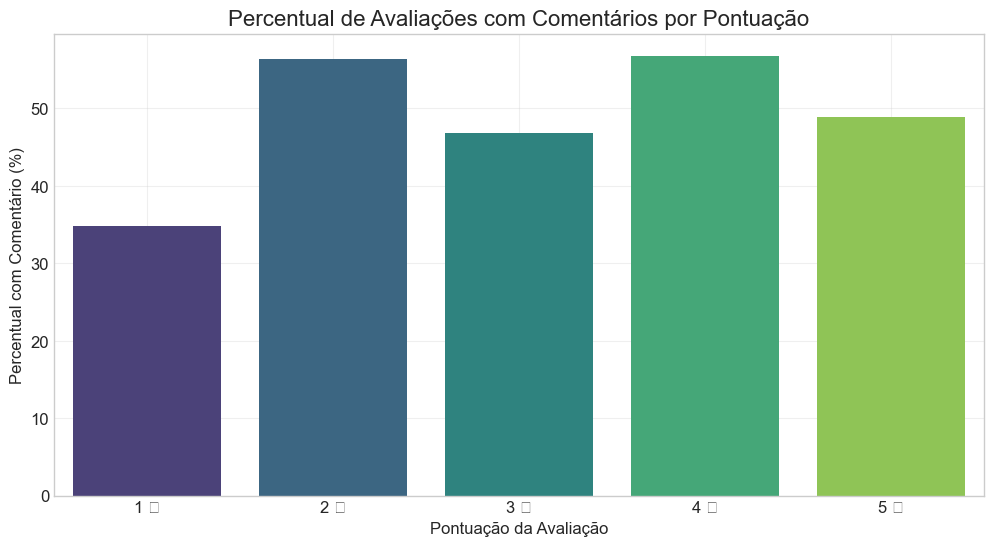


Percentual de avaliações com comentários por pontuação:
              Percentual com Comentário
review_score                           
1                             34.782609
2                             56.410256
3                             46.808511
4                             56.818182
5                             48.936170


In [8]:
# Analisando presença de comentários por avaliação
reviews['has_comment'] = reviews['review_comment_message'].notna()

# Contagem de avaliações com e sem comentários por pontuação
comment_by_score = reviews.groupby(['review_score', 'has_comment']).size().unstack().fillna(0)
comment_by_score.columns = ['Sem Comentário', 'Com Comentário']

# Calculando percentual de comentários por pontuação
comment_by_score['Total'] = comment_by_score.sum(axis=1)
comment_by_score['Percentual com Comentário'] = comment_by_score['Com Comentário'] / comment_by_score['Total'] * 100

# Visualizando percentual de comentários por pontuação
plt.figure(figsize=(12, 6))
sns.barplot(x=comment_by_score.index, y=comment_by_score['Percentual com Comentário'], palette='viridis')
plt.title('Percentual de Avaliações com Comentários por Pontuação', fontsize=16)
plt.xlabel('Pontuação da Avaliação', fontsize=12)
plt.ylabel('Percentual com Comentário (%)', fontsize=12)
plt.xticks(range(5), ['1 ★', '2 ★', '3 ★', '4 ★', '5 ★'])
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/comment_percentage_by_score.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPercentual de avaliações com comentários por pontuação:")
print(comment_by_score[['Percentual com Comentário']])

## Análise de Sazonalidade nas Avaliações

C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\1379211513.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='review_month', y='mean', data=monthly_reviews, palette='viridis')


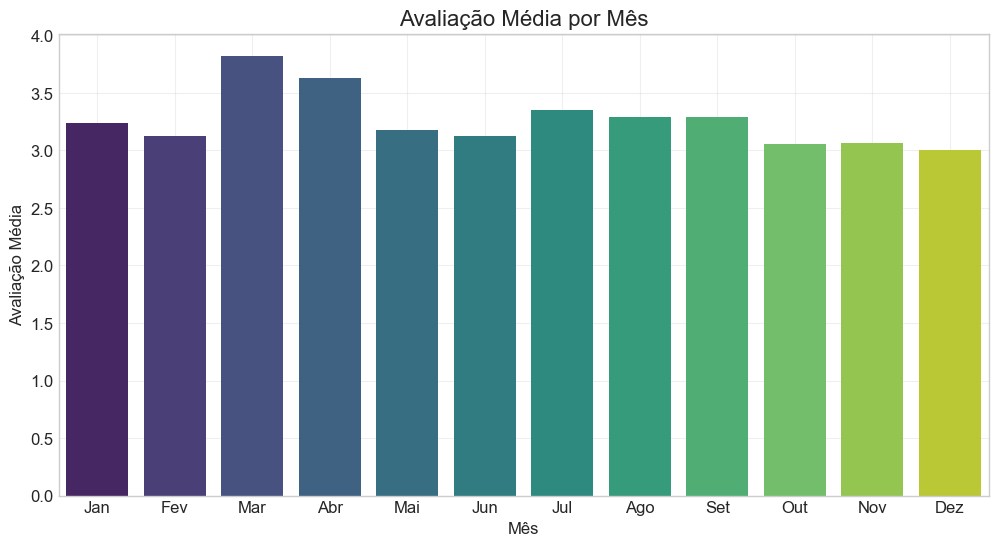

C:\Users\Douglas\AppData\Local\Temp\ipykernel_4176\1379211513.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='review_dayofweek', y='mean', data=weekday_reviews, palette='viridis')


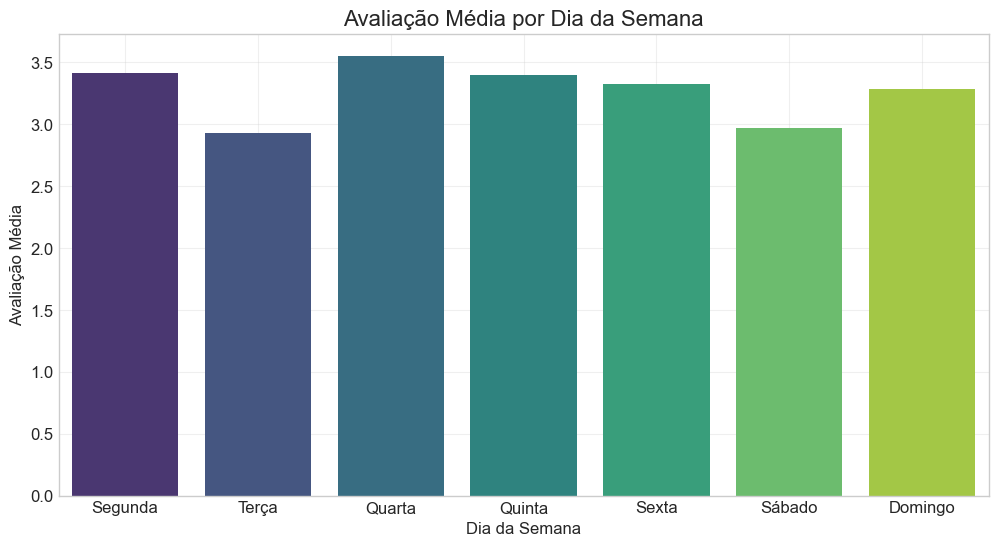

In [9]:
# Convertendo datas para datetime
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])

# Extraindo mês e dia da semana
reviews['review_month'] = reviews['review_creation_date'].dt.month
reviews['review_dayofweek'] = reviews['review_creation_date'].dt.dayofweek

# Analisando avaliações médias por mês
monthly_reviews = reviews.groupby('review_month')['review_score'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='review_month', y='mean', data=monthly_reviews, palette='viridis')
plt.title('Avaliação Média por Mês', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Avaliação Média', fontsize=12)
plt.xticks(range(12), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/review_by_month.png', dpi=300, bbox_inches='tight')
plt.show()

# Analisando avaliações médias por dia da semana
weekday_reviews = reviews.groupby('review_dayofweek')['review_score'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='review_dayofweek', y='mean', data=weekday_reviews, palette='viridis')
plt.title('Avaliação Média por Dia da Semana', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Avaliação Média', fontsize=12)
plt.xticks(range(7), ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'])
plt.grid(True, alpha=0.3)
plt.savefig('../reports/figures/review_by_weekday.png', dpi=300, bbox_inches='tight')
plt.show()

## Salvando Dados Processados

In [10]:
# Salvando dados processados para uso em outros notebooks
os.makedirs('../data/processed', exist_ok=True)

# Salvando dados de segmentação RFM
rfm_data.to_csv('../data/processed/customer_rfm_segmentation.csv', index=False)

# Salvando dados de avaliações processados
reviews_orders.to_csv('../data/processed/reviews_with_order_data.csv', index=False)

print("Análise de comportamento do cliente concluída!")

Análise de comportamento do cliente concluída!


## Conclusões

Nesta análise detalhada do comportamento dos clientes do e-commerce da Olist, identificamos vários insights importantes:

1. **Frequência de Compra**: A maioria dos clientes faz apenas uma compra, indicando uma oportunidade para estratégias de retenção e fidelização.

2. **Segmentação RFM**: Identificamos diferentes segmentos de clientes com base em recência, frequência e valor monetário, permitindo estratégias de marketing personalizadas para cada grupo.

3. **Satisfação do Cliente**: A distribuição de avaliações mostra uma polarização, com muitas avaliações 5 estrelas e também um número significativo de avaliações 1 estrela, resultando em um NPS que precisa de melhorias.

4. **Fatores de Satisfação**: O tempo de entrega e, especialmente, atrasos na entrega têm forte correlação com avaliações negativas, indicando a importância da logística na satisfação do cliente.

5. **Variações Geográficas**: Existem diferenças significativas nas avaliações médias entre estados, sugerindo possíveis problemas logísticos regionais.

6. **Comentários**: Clientes insatisfeitos (avaliações 1-2) são muito mais propensos a deixar comentários do que clientes satisfeitos, o que pode distorcer a percepção geral da satisfação.

7. **Sazonalidade**: Observamos variações nas avaliações médias ao longo do ano e da semana, que podem estar relacionadas a períodos de maior demanda e pressão logística.

Estes insights podem orientar estratégias de marketing, logística e atendimento ao cliente para melhorar a satisfação, aumentar a retenção e maximizar o valor do cliente ao longo do tempo.